In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Open the H5 file
file = h5py.File('dataM.h5', 'r')

# Create empty lists to store the preprocessed data
Matrix_13_data = []
Matrix_16_data = []

In [3]:
for i in range(1, 1001):
    # Construct the dataset paths
    Matrix_13_path = f"dataset_group/Matrix_13_{i}"
    Matrix_16_path = f"dataset_group/Matrix_16_{i}"    
    # Load vector_13 and vector_16 from the H5 file
    Matrix_13 = np.array(file[Matrix_13_path])
    Matrix_16 = np.array(file[Matrix_16_path])
    
    # Add the data to the respective lists
    Matrix_13_data.append(Matrix_13)
    Matrix_16_data.append(Matrix_16)
    
# Close the H5 file
file.close()

In [4]:
# Convert the lists to numpy arrays
Matrix_13_data = np.array(Matrix_13_data)
Matrix_16_data = np.array(Matrix_16_data)

# Normalize the data (optional, good idea?)
# vector_13_data = vector_13_data / np.max(vector_13_data)
# vector_16_data = vector_16_data / np.max(vector_16_data)

# Reshape Matrix_13_data to (1000, 16, 16) and Matrix_16_data to (1000, 16, 16)
Matrix_13_data = np.reshape(Matrix_13_data, (1000, 16, 16))
Matrix_16_data = np.reshape(Matrix_16_data, (1000, 16, 16))

In [5]:
# Split the dataset into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * Matrix_13_data.shape[0])

x_train = Matrix_13_data[:train_size]
y_train = Matrix_16_data[:train_size]

x_test = Matrix_13_data[train_size:]
y_test = Matrix_16_data[train_size:]

In [6]:
# W being the 'hypermatrix' 
W = tf.Variable(tf.random.normal((16, 16, 16, 16)))

# Apply einsum to map x_train to y_train
y_pred = tf.einsum('aij,klij->akl', x_train, W)


In [7]:
# Define a loss function
# loss = tf.reduce_mean(tf.square(y_train - y_pred))

# Create an optimizer and training operation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [8]:
# Sanity check
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
# Define the weights for each loss term
main_loss_weight = 0
column_sum_loss_weight = 1.0
symmetry_loss_weight = 1.0
identical_values_loss_weight = 1.0

In [22]:
# Training loop
num_epochs = 400
batch_size = 32
num_batches = int(np.ceil(x_train.shape[0] / batch_size))

for epoch in range(num_epochs):
    for i in range(num_batches):
        # Select the mini-batch
        x_batch = x_train[i * batch_size: (i + 1) * batch_size]
        y_batch = y_train[i * batch_size: (i + 1) * batch_size]

        # Perform forward pass and compute loss
        with tf.GradientTape() as tape:
            y_pred = tf.einsum('aij,klij->akl', x_batch, W)

            # Compute the main loss
            main_loss = tf.keras.losses.MeanSquaredError()(y_batch, y_pred)

            # Compute the column sum constraint
            column_sum_loss = tf.reduce_sum(tf.abs(tf.reduce_sum(y_pred, axis=1)))

            # Compute the symmetry constraint
            symmetry_loss = tf.reduce_sum(tf.abs(y_pred - tf.transpose(y_pred, perm=[0, 2, 1])))

            # Compute the identical non-zero values constraint
            mask = tf.cast(x_batch != 0, dtype=tf.float32)
            identical_values_loss = tf.reduce_sum(mask * tf.abs(y_pred - y_batch))

            # Combine the losses
            loss_value = (main_loss_weight * main_loss + 
                          column_sum_loss_weight * column_sum_loss + 
                          symmetry_loss_weight * symmetry_loss + 
                          identical_values_loss_weight * identical_values_loss)

        # Compute gradients and update weights
        gradients = tape.gradient(loss_value, [W])
        optimizer.apply_gradients(zip(gradients, [W]))
    
    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_value:.4f}")


Epoch 100/400, Loss: 1073.9814
Epoch 200/400, Loss: 995.8617
Epoch 300/400, Loss: 929.6954
Epoch 400/400, Loss: 871.1721


In [168]:
# Evaluation
y_pred_test = tf.einsum('aij,klij->akl', x_test, W)

# Select a random index from the test set
random_index = np.random.randint(low=0, high=y_test.shape[0])

# Select the predicted and ground truth matrices at the random index
predicted_matrix = y_pred_test[random_index]
ground_truth_matrix = y_test[random_index]


# Print the selected matrices for comparison
#print("Predicted Matrix:")
# print(predicted_matrix)
print(predicted_matrix.shape)
#print("Ground Truth Matrix:")
#print(ground_truth_matrix)
print(ground_truth_matrix.shape)

(16, 16)
(16, 16)


In [169]:
def find_zeros_map(matrix):
    # Find the zeros map
    zeros_map_int = tf.cast(matrix != 0, dtype=tf.float32)
    return zeros_map_int

zeros_map = find_zeros_map(Matrix_13_data[1]).numpy()
non_zeros_map = 1-zeros_map
print(zeros_map)
print(non_zeros_map)

[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]]
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0

In [170]:
def compute_intermediate_matrices(predicted_matrix, ground_truth_matrix, zeros_map, non_zeros_map):
    # Compute the intermediate matrices. This does element-wise multiplication (dot product) of the indices and the input matrix
    int_matrix1 = non_zeros_map * predicted_matrix # Predicted values
    int_matrix2 = zeros_map * ground_truth_matrix  # Real values
    return int_matrix1, int_matrix2

def compute_column_sums(matrix):
    # Compute the column-wise sum of the matrix
    column_sums = tf.reduce_sum(matrix, axis=0)
    return column_sums

def compute_scalars(int_matrix1_sum, int_matrix2_sum):
    # Convert both tensors to the same type (float32)
    int_matrix1_sum = tf.cast(int_matrix1_sum, tf.float32)
    int_matrix2_sum = tf.cast(int_matrix2_sum, tf.float32)

    # Normalize the sums
    int_matrix1_sum_normalized = int_matrix1_sum / tf.norm(int_matrix1_sum)
    int_matrix2_sum_normalized = int_matrix2_sum / tf.norm(int_matrix2_sum)

    # Compute the scalar multipliers to make each column sum to zero
    scalars = int_matrix2_sum_normalized / tf.maximum(int_matrix1_sum_normalized, 1)  # Avoid division by zero
    return scalars

def apply_scalars(int_matrix1, scalars):
    # Apply the scalar multipliers to int_matrix1
    corrected_matrix = int_matrix1 * tf.reshape(scalars, [1, -1])
    return corrected_matrix

In [173]:
# Compute the intermediate matrices
int_matrix1, int_matrix2 = compute_intermediate_matrices(predicted_matrix, ground_truth_matrix, zeros_map, non_zeros_map)
# print("predicted values: ",int_matrix1.numpy())
# print("real values: ",int_matrix2)
# Compute the column-wise sums of the predicted and real values
int_matrix1_sum = compute_column_sums(int_matrix1)
int_matrix2_sum = compute_column_sums(int_matrix2)

# Compute the scalar multipliers
scalars = compute_scalars(int_matrix1_sum, int_matrix2_sum)

# Apply the scalar multipliers to the predicted values
corrected_matrix = apply_scalars(int_matrix1, scalars)

# Add int_matrix2 and corrected_matrix to get the final matrix
# final_matrix = int_matrix2 + corrected_matrix

#As the above code runs into issues [it scales off into oblivion], we currently just smooth out the predicted values with the real ones and use the predicted values as-is.

final_matrix = int_matrix2 + int_matrix1


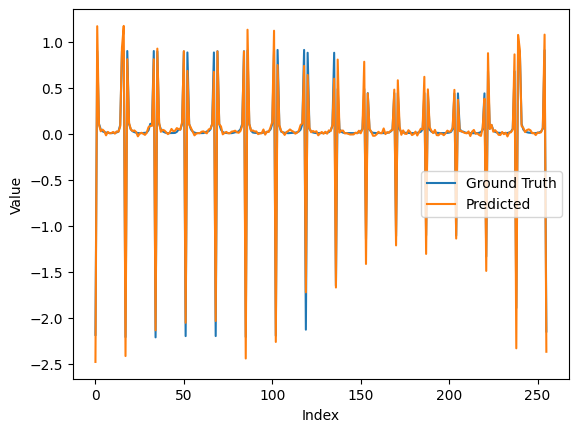

In [176]:
import matplotlib.pyplot as plt

# Flatten the ground truth and predicted matrices
ground_truth_vector = np.array(ground_truth_matrix, order='F').flatten()
predicted_vector = np.array(predicted_matrix, order='F').flatten()
final_vector = np.array(final_matrix, order='F').flatten()

#print(ground_truth_vector)
# Create x-axis values for the plot
x = range(len(ground_truth_vector))

# Plot the ground truth and predicted vectors
plt.plot(x, ground_truth_vector, label='Ground Truth')
plt.plot(x, predicted_vector, label='Predicted')
#plt.plot(x, final_vector, label='Processed')

# Set plot labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()